In [3]:
"""
.................................................................
Olivetti faces dataset - image recognition
AT&T Laboratories, Cambridge 
http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
.................................................................
"""

print(__doc__)

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces

# fetch data:

data = fetch_olivetti_faces()

print(data.images.shape)    # (400,64,64)        # 400: 40 people, 10 images each
print(data.target.shape)    # (400,)             # labels: 0-39

# train-test split:

data_flat = data.images.reshape(400,4096)       # 4096=64*64

train=data_flat.reshape(40,10,4096)
train=train[:,:7,:]                             # first 7 columns, 7*40=280 images
train=train.reshape(280,4096)                   # 280 training images

test=data_flat.reshape(40,10,4096)
test=test[:,7:,:]                               # last 3 columns, 3*40=120 images
test=test.reshape(120,4096)                     # 120 test images

# split labels

train_labels=(data.target.reshape(40,10)[:,:7]).reshape(280,)
test_labels=(data.target.reshape(40,10)[:,7:]).reshape(120,)

#print(train_labels)
#print(test_labels)


.................................................................
Olivetti faces dataset - image recognition
AT&T Laboratories, Cambridge 
http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html
.................................................................

(400, 64, 64)
(400,)


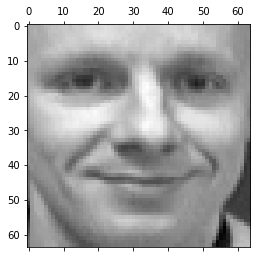

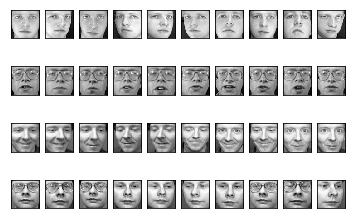

In [4]:
# Visualize images:

# data_flat: (400,4096)

# Check image no. 200, e.g.:

v=data_flat[200,:]
plt.matshow(v.reshape(64,64),cmap=plt.cm.gray)
plt.show()

# Visualize the first 40 images:

fig, axes = plt.subplots(4,10)
for coef, ax in zip(data_flat[:40,:], axes.ravel()):
    ax.matshow(coef.reshape(64,64), cmap=plt.cm.gray)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [5]:
# one-hot encoding:

import pandas as pd

train_labels=pd.get_dummies(train_labels).values
test_labels=pd.get_dummies(test_labels).values

print(test_labels.shape)

(120, 40)


In [6]:
x = tf.placeholder(tf.float32, shape=[None,4096])     # input images placeholder
d = tf.placeholder(tf.float32, shape=[None,40])      # labels placeholder      

def weight(shape):                              
    return tf.Variable(tf.random_normal(shape, stddev=0.1))

def bias(shape):
    return tf.Variable(tf.constant(0.1, shape=shape))

def conv2d(x, W):                                        # zero-padded: output size = input size
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

# first conv layer

W_conv1 = weight([5, 5, 1, 32])    # 32 features
b_conv1 = bias([32])

x_image = tf.reshape(x, [-1, 64, 64, 1])

conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
pool1 = max_pool(conv1)

# second conv layer

W_conv2 = weight([5, 5, 32, 64])
b_conv2 = bias([64])

conv2 = tf.nn.relu(conv2d(pool1, W_conv2) + b_conv2)
pool2 = max_pool(conv2)

# third conv layer

W_conv3 = weight([5, 5, 64, 64])
b_conv3 = bias([64])               # 64: number of output features

conv3 = tf.nn.relu(conv2d(pool2, W_conv3) + b_conv3)
pool3 = max_pool(conv3)

# fully-connected layer

W_fc1 = weight([8 * 8 * 64, 100])   #100: it's our choice, no. of neurons in the fully-connected layer
b_fc1 = bias([100])

pool3_flat = tf.reshape(pool3, [-1, 8*8*64])
fc1 = tf.nn.relu(tf.matmul(pool3_flat, W_fc1) + b_fc1)

# dropout layer

keep_prob = tf.placeholder(tf.float32)
fc1_drop = tf.nn.dropout(fc1, keep_prob)

# output layer

W_fc2 = weight([100, 40])
b_fc2 = bias([40])

y = tf.matmul(fc1_drop, W_fc2) + b_fc2

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=d, logits=y))
optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(d, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [7]:
# Batch learning:

def next_batch(batchsize, data, labels):    # with this function we can make batches out of the training set
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:batchsize]
    data_shuffle = [data[i] for i in idx]
    labels_shuffle = [labels[i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)    
                        # output: a shuffled sequence of 'batchsize' number of training points and the corresponding labels

batch_x,batch_d = next_batch(5,train,train_labels)       # example: batch of 5 images


In [ ]:
with tf.Session() as sess:                              # batch training, 1000 iterations
    sess.run(tf.global_variables_initializer())
    for _ in range(1000):
        batch_x,batch_d = next_batch(5,train,train_labels)
        optimizer.run(feed_dict={x: batch_x, d: batch_d, keep_prob: 0.5})            # dropout rate: 50%
    print('test accuracy:', accuracy.eval(feed_dict={x: test, d: test_labels, keep_prob: 1.0}))